<a href="https://colab.research.google.com/github/nshzk8975/fastai/blob/master/Lesson3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

# **多ラベル分類**

In [0]:
! pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.3)


In [0]:
! mkdirr -p ~/.kaggle/  
! mv kaggle.json ~/.kaggle/ 

/bin/bash: mkdirr: command not found
mv: cannot stat 'kaggle.json': No such file or directory


In [0]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

FileNotFoundError: ignored

# **segmentation** 

**データの確認**

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_08001.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_008940.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08127.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0006R0_f03930_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_06960_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f03240_P.png')]

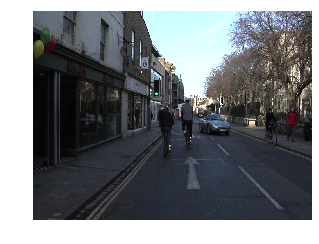

In [15]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [20]:
get_y_fn(fnames[0])

PosixPath('/root/.fastai/data/camvid/labels/0016E5_08001_P.png')

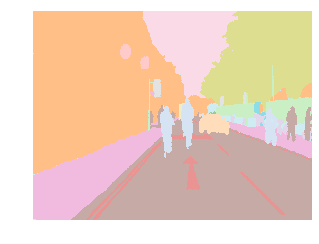

In [21]:
img_lbl = get_y_fn(fnames[0])
img = open_mask(img_lbl)
img.show(figsize=(5,5))

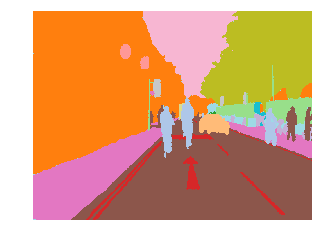

In [28]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [29]:
mask.shape[1:]

torch.Size([720, 960])

In [30]:
mask.shape

torch.Size([1, 720, 960])

In [31]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [30, 30, 30,  ..., 17, 17, 17],
          [30, 30, 30,  ..., 17, 17, 17],
          [30, 30, 30,  ..., 17, 17, 17]]]))

In [32]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [33]:
np.loadtxt(path/'valid.txt', dtype=str)

array(['0016E5_07959.png', '0016E5_07961.png', '0016E5_07963.png', '0016E5_07965.png', ..., '0016E5_08153.png',
       '0016E5_08155.png', '0016E5_08157.png', '0016E5_08159.png'], dtype='<U16')

**データセット**

In [34]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 15068MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

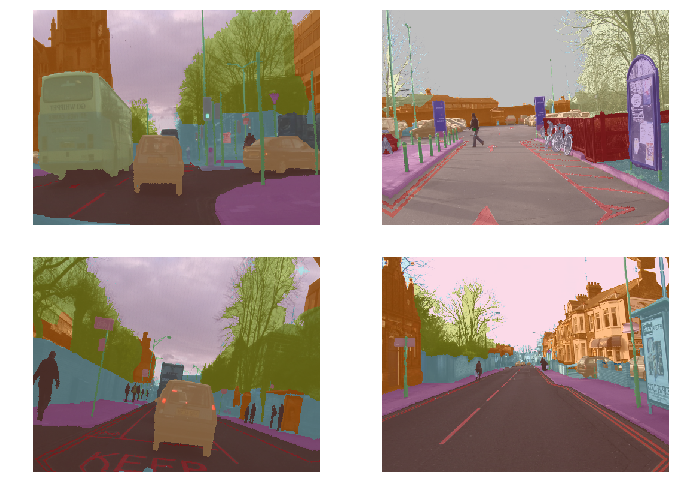

In [37]:
data.show_batch(2, figsize=(10,7))

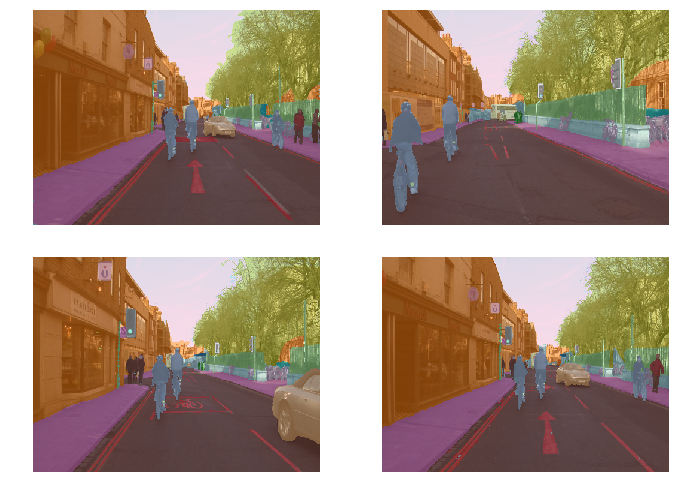

In [39]:
data.show_batch(2, figsize=(10, 7), ds_type=DatasetType.Valid)

**モデル作成**

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [46]:
void_code

30

In [0]:
metrics = acc_camvid

In [0]:
wd = 1e-2

In [50]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 50980210.07it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


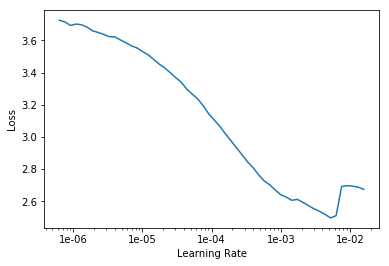

In [51]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 1e-4

In [53]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.423513,1.822001,0.583229,01:45
1,1.582891,1.107954,0.740633,01:40
2,1.126307,0.891846,0.795211,01:40
3,0.885689,0.765143,0.822622,01:40
4,0.751684,0.641876,0.828238,01:40
5,0.649239,0.542112,0.853916,01:40
6,0.590525,0.563660,0.841814,01:40
7,0.562896,0.513123,0.864122,01:40
8,0.515527,0.397520,0.888291,01:40
9,0.471490,0.379599,0.892937,01:40


In [0]:
learn.save("stage-1")

In [55]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

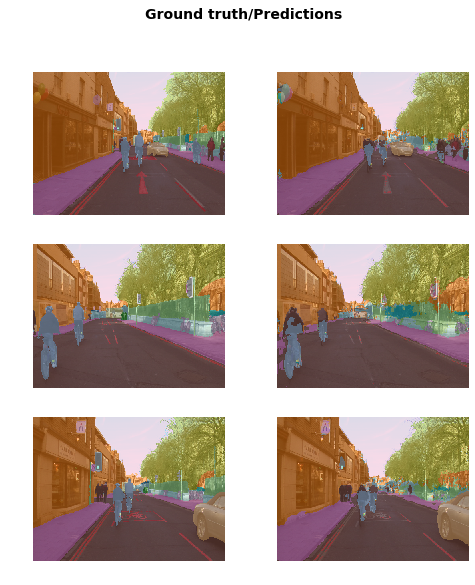

In [56]:
learn.show_results(rows=3, figsize=(8,9))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


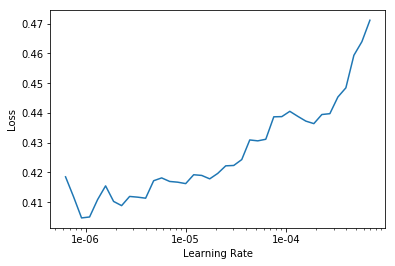

In [57]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)